#### Solving the nonlinear Schrödinger equation with pseudospectral (with periodic boundary conditions) semi-discretization  in space and different time integrators in time.
\begin{align}\label{Schrodinger_eqn}
    i u_t + u_{xx} + \beta |u|^2 u & = 0, \text{on} \ [x_L,x_R] \times (0,T], \\
    u(x,0) = \textrm{sech}(x).
\end{align}

####  This code will generate convergence plots (Figure 1 in the manuscript) for the NLS equation with 2- and 3-soliton solutions. It will utilize various time-stepping methods and a Fourier pseudo-spectral approximation in space. Additionally, the code will produce the numerical values in Table 2 of the manuscript.

In [1]:
# Required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from IPython.display import clear_output, display, Math
from TimeIntegrators import ImEx_schemes, Op_Sp_Coeff
from time import time

In [2]:
# Choose a particular case
#q = 8; sol = 2; inv = 1
q = 18; sol = 3; inv = 1

# time-stepping methods
Mthds_B = ['ImEx3','ImEx4']; Mthds_R = ['ImEx3(R)','ImEx4(R)']; Mthds_SP = ['S2','AK4']
Stage = [4,6]; Order = [3,4]; em_Or = [2,3]; Sch_No = [3,4]
SP_Stage = [2,5]; SP_Order = [2,4]; SP_Sch_No = [1,2];  

# Different casese
if q == 8 and sol == 2 and inv == 1: 
    xL = -35; xR = 35; L = xR-xL; m1 = 16; N =m1*L; t0 = 0; DT = [0.01,0.01]; SP_DT = [0.01,0.01]; T = 5
elif q == 18 and sol == 3 and inv == 1: 
    xL = -35; xR = 35; L = xR-xL; m1 = 32; N =m1*L; t0 = 0; DT = [0.01,0.01]; SP_DT = [0.01,0.01] ; T = 5

In [3]:
# If path doesn’t exist we create a new path
eqn = 'NLS_q%d_Inv%d'%(q,inv)
import os
path1 = './Data/%s'%(eqn)
path2 = './Figures/%s'%(eqn)
if not os.path.exists(path1):
   os.makedirs(path1)
if not os.path.exists(path2):
   os.makedirs(path2)

In [4]:
# Stiff part of the right hand side function of the ODE system 
def rhsNlsStiff(u,xi):
    ucomp = u[:N]+ 1j *u[N:]
    uhat = np.fft.fft(ucomp)
    duhat = 1j*xi**2*uhat
    du = np.fft.ifft(duhat)
    rhs_comp= -du
    dudt = np.concatenate((rhs_comp.real,rhs_comp.imag)).astype('float64')
    return dudt

# Non-stiff part of right hand side function of the ODE system 
def rhsNlsNonStiff(u,q):
    ucomp = u[:N]+ (1j) *u[N:]
    rhs_comp= (1j)*q*(np.abs(ucomp))**2*ucomp
    dudt = np.concatenate((rhs_comp.real,rhs_comp.imag)).astype('float64')
    return dudt

def eta1(u,dx):  # Invariant: first quantity
    V = u[:N]; W = u[N:]
    return dx*np.sum(V**2+W**2)

def eta2(u,dx,q):   # Invariant: second quantity
    V = u[:N]; W = u[N:]
    return np.sum((np.diff(V)**2+np.diff(W)**2)/dx - 0.5*q*dx*(V[:-1]**2+W[:-1]**2)**2)

def rgam(gamma,u,inc,E_old,inv,dx,q):
    uprop = u + np.dot(gamma,inc)  
    if inv == 1:
        E_prop = np.array([eta1(uprop,dx)])
    elif inv == 2:
        E_prop = np.array([eta1(uprop,dx),eta2(uprop,dx,q)])
    return E_prop-E_old

def NLS_True_Sol(t,x,q):
    N = len(x)
    if q == 2:
        ut = np.exp(1j*t)/np.cosh(x)
    elif q == 8:
        sechx = 1./np.cosh(x)
        ut = np.exp(1j*t)*sechx*( 1+(3/4)*sechx**2*(np.exp(8*1j*t)-1) )/( 1-(3/4)*sechx**4*np.sin(4*t)**2 )
    elif q == 18:
        ut = (2*(3*np.exp(t*25*1j)*np.exp(x) + 15*np.exp(t*9*1j)*np.exp(9*x) + 48*np.exp(t*25*1j)*np.exp(7*x) + 48*np.exp(t*25*1j)*np.exp(11*x) + 24*np.exp(t*33*1j)*np.exp(3*x) + 54*np.exp(t*33*1j)*np.exp(5*x) + 3*np.exp(t*25*1j)*np.exp(17*x) + 54*np.exp(t*33*1j)*np.exp(13*x) + 24*np.exp(t*33*1j)*np.exp(15*x) + 135*np.exp(t*41*1j)*np.exp(9*x) + 30*np.exp(t*49*1j)*np.exp(5*x) + 120*np.exp(t*49*1j)*np.exp(7*x) + 120*np.exp(t*49*1j)*np.exp(11*x) + 30*np.exp(t*49*1j)*np.exp(13*x) + 60*np.exp(t*57*1j)*np.exp(9*x)))/(3*(np.exp(t*24*1j) + 10*np.exp(6*x) + 10*np.exp(12*x) + 45*np.exp(t*8*1j)*np.exp(8*x) + 45*np.exp(t*8*1j)*np.exp(10*x) + 18*np.exp(t*16*1j)*np.exp(4*x) + 9*np.exp(t*24*1j)*np.exp(2*x) + 18*np.exp(t*16*1j)*np.exp(14*x) + 64*np.exp(t*24*1j)*np.exp(6*x) + 36*np.exp(t*24*1j)*np.exp(8*x) + 36*np.exp(t*24*1j)*np.exp(10*x) + 64*np.exp(t*24*1j)*np.exp(12*x) + 18*np.exp(t*32*1j)*np.exp(4*x) + 9*np.exp(t*24*1j)*np.exp(16*x) + np.exp(t*24*1j)*np.exp(18*x) + 18*np.exp(t*32*1j)*np.exp(14*x) + 45*np.exp(t*40*1j)*np.exp(8*x) + 45*np.exp(t*40*1j)*np.exp(10*x) + 10*np.exp(t*48*1j)*np.exp(6*x) + 10*np.exp(t*48*1j)*np.exp(12*x)))  
    
    u = np.zeros((2*N)); u[:N] = ut.real; u[N:] = ut.imag 
    return u

#### ImEx methods

In [5]:
def ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthdname,rkim,rkex,c,b,dt):
    
    # spatial discretization
    L = xR-xL; x = np.linspace(xL, xR, N+1)[:-1] # exclude the right boundary point
    dx = x[1]-x[0]; xi = np.fft.fftfreq(N) * N * 2*np.pi / L
    
    # Initial conditions  
    tt = np.zeros(1); t = t0; tt[0] = t # time
    u0 = np.zeros((2*N))
    for i, xc in enumerate(x):
        u0[i] = 1./np.cosh(xc)
        
    uu = np.zeros((1,np.size(u0))); uu[0,:] = u0.copy() # solution

    s = len(rkim); Rim = np.zeros((s,len(u0))); Rex = np.zeros((s,len(u0))) 
    
    t_start = time()
    while t < T and not np.isclose(t, T):
        if t + dt > T:
            dt = T - t
        for i in range(s):
            rhs = uu[-1].copy()
            if i>0:
                for j in range(i):
                    rhs += dt*(rkim[i,j]*Rim[j,:] + rkex[i,j]*Rex[j,:])

            Coeff =1/(1-dt*rkim[i,i]*(-1j*xi*xi))
            g_j_comp = np.fft.ifft(Coeff*np.fft.fft(rhs[:N]+1j*rhs[N:]))
            g_j = np.concatenate((g_j_comp.real,g_j_comp.imag)).astype('float64')
            Rim[i,:] = f_stiff(g_j,xi)
            Rex[i,:] = f_non_stiff(g_j,q)

        inc = dt*sum([ b[j]*(Rim[j]+Rex[j]) for j in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)   
    t_end = time()
    req_t = t_end-t_start 
    return req_t, tt, uu

#### ImEx(MR) methods

In [6]:
def MR_ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthdname,rkim,rkex,c,b,bhat,inv,dt):
    
    # spatial discretization
    L = xR-xL; x = np.linspace(xL, xR, N+1)[:-1] # exclude the right boundary point
    dx = x[1]-x[0]; xi = np.fft.fftfreq(N) * N * 2*np.pi / L
    
    # Initial conditions  
    tt = np.zeros(1); t = t0; tt[0] = t # time
    u0 = np.zeros((2*N))
    for i, xc in enumerate(x):
        u0[i] = 1./np.cosh(xc)
        
    uu = np.zeros((1,np.size(u0))); uu[0,:] = u0.copy() # solution

    s = len(rkim); Rim = np.zeros((s,len(u0))); Rex = np.zeros((s,len(u0))); 
    gamma0 = np.zeros(inv);
    
    t_start = time()
    while t < T and not np.isclose(t, T):
        if t + dt > T:
            dt = T - t        
        for i in range(s):
            rhs = uu[-1].copy()
            if i>0:
                for j in range(i):
                    rhs += dt*(rkim[i,j]*Rim[j,:] + rkex[i,j]*Rex[j,:] )
                    
                    
            Coeff =1/(1-dt*rkim[i,i]*(-1j*xi*xi))
            g_j_comp = np.fft.ifft(Coeff*np.fft.fft(rhs[:N]+1j*rhs[N:]))
            g_j = np.concatenate((g_j_comp.real,g_j_comp.imag)).astype('float64')
            Rim[i,:] = f_stiff(g_j,xi)
            Rex[i,:] = f_non_stiff(g_j,q)
        
        inc1 = dt*sum([ b[i]*(Rim[i]+Rex[i]) for i in range(s)])  
        inc2 = dt*sum([ bhat[i]*(Rim[i]+Rex[i]) for i in range(s)]) 
        unew = uu[-1]+inc1; 
        
        if inv == 1:
            inc = np.array([inc1]); E_old = np.array([eta1(uu[-1],dx)])
        elif inv == 2:
            inc = np.array([inc1,inc2]); E_old = np.array([eta1(uu[-1],dx), eta2(uu[-1],dx,q)])
                
        # fsolve
        ga_fsolve, info, ier, mesg = fsolve(rgam,gamma0,args=(unew,inc,E_old,inv,dx,q),full_output=True,xtol = 1e-12)
        gamma = ga_fsolve; gamma0 = ga_fsolve   

        unew = unew + np.dot(gamma,inc); t+=(1+sum(gamma))*dt
        tt = np.append(tt, t); uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        
    t_end = time()
    req_t = t_end-t_start
    return req_t, tt, uu

#### Time-splitting pseudospectral methods

In [7]:
# This is an implementation of an operator splitting 
# substeps
def sol_nl_part(u, q, dt):
    u_st = np.exp(1j*q*np.abs(u)**2*dt)*u
    return u_st
              
def sol_l_part(u, xi, dt):
    uhat = np.fft.fft(u)
    u_st_hat = np.exp(-1j*xi**2*dt)*uhat
    u_st = np.fft.ifft(u_st_hat)
    return u_st

def Op_Split_Exact_Solve(Mthdname,sol_nl_part,sol_l_part,q,xL,xR,N,t0,T,a,b,dt):
    # spatial discretization
    L = xR-xL; x = np.linspace(xL, xR, N+1)[:-1] # exclude the right boundary point
    dx = x[1]-x[0]; xi = np.fft.fftfreq(N) * N * 2*np.pi / L
    
    tt = np.zeros(1); t = t0; tt[0] = t # time
    u0 = np.zeros((2*N))
    for i, xc in enumerate(x):
        u0[i] = 1./np.cosh(xc)
        
    uu = np.zeros((1,np.size(u0))); uu[0,:] = u0.copy() # solution
    u_comp = u0[:N]+ (1j) *u0[N:]; 
    
    t_start = time()
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        u_st = u_comp.copy()  
        for j in range(len(a)):
            u_st = sol_nl_part(u_st,q,a[j]*dt)
            u_st = sol_l_part(u_st,xi,b[j]*dt)
            
        u_comp = u_st.copy(); t+=dt
            
        unew = np.concatenate((u_comp.real,u_comp.imag)).astype('float64')
        tt = np.append(tt, t); uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        
    t_end = time()
    req_t = t_end-t_start 
    return req_t, tt, uu

#### Test run

In [8]:
f_stiff = rhsNlsStiff; f_non_stiff = rhsNlsNonStiff; 
idx = 0
rkim, rkex, c, b, bhat = ImEx_schemes(Stage[idx],Order[idx],em_Or[idx],Sch_No[idx]);dt = DT[idx];  
b_req_t, b_tt, b_uu = ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthds_B[idx],rkim,rkex,c,b,dt)

In [9]:
r_req_t, r_tt, r_uu = MR_ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthds_R[idx],rkim,rkex,c,b,bhat,inv,dt)

## Data for the table

#### Compute solution by ImEx methods

In [10]:
B_data = {'Mthds_B': Mthds_B,
        'B: dt': DT,
        'Domain':'[%d,%d]'%(xL,xR),
        'N': N,
        't0': t0,
        'tf':'%1.1f'%(T),
        'q':'%d'%(q)}
B_df = pd.DataFrame(B_data)

f_stiff = rhsNlsStiff; f_non_stiff = rhsNlsNonStiff; 

# ImEx with multiple relaxation
B_RT = []; B_tt = []; B_uu = [];  
for idx in range(len(Mthds_B)):
    rkim, rkex, c, b, bhat = ImEx_schemes(Stage[idx],Order[idx],em_Or[idx],Sch_No[idx]);dt = DT[idx];  
    req_t, tt, uu = ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthds_B[idx],rkim,rkex,c,b,dt)
    B_RT.append(req_t); B_tt.append(tt); B_uu.append(uu)

#### Compute solution by ImEx with relaxation

In [11]:
R_data = {'Mthds_R': Mthds_R,
        'R: dt': DT,
        'Domain':'[%d,%d]'%(xL,xR),
        'N': N,
        't0': t0,
        'tf':'%1.1f'%(T),
        'q':'%d'%(q)}
R_df = pd.DataFrame(R_data)

f_stiff = rhsNlsStiff; f_non_stiff = rhsNlsNonStiff; 

# ImEx with multiple relaxation
R_RT = []; R_tt = []; R_uu = [];  
for idx in range(len(Mthds_R)):
    rkim, rkex, c, b, bhat = ImEx_schemes(Stage[idx],Order[idx],em_Or[idx],Sch_No[idx]);dt = DT[idx];  
    req_t, tt, uu = MR_ImEx_Sol(f_stiff,f_non_stiff,q,t0,T,xL,xR,N,Mthds_R[idx],rkim,rkex,c,b,bhat,inv,dt)
    R_RT.append(req_t); R_tt.append(tt); R_uu.append(uu)

#### Compute solution by time splitting pseudospectral methods

In [12]:
SP_data = {'Mthds_SP': Mthds_SP,
        'SP: dt': SP_DT,
        'Domain':'[%d,%d]'%(xL,xR),
        'N': N,
        't0': t0,
        'tf':'%1.1f'%(T),
        'q':'%d'%(q)}
SP_df = pd.DataFrame(SP_data)

f_stiff = rhsNlsStiff; f_non_stiff = rhsNlsNonStiff; 

# Time splitting methods
SP_RT = []; SP_tt = []; SP_uu = [];  
for idx in range(len(Mthds_SP)):
    OpSp_a, OpSp_b = Op_Sp_Coeff(SP_Stage[idx],SP_Order[idx],SP_Sch_No[idx]); dt = SP_DT[idx]; 
    req_t, tt, uu = Op_Split_Exact_Solve(Mthds_SP[idx],sol_nl_part,sol_l_part,q,xL,xR,N,t0,T,OpSp_a,OpSp_b,dt)

    SP_RT.append(req_t); SP_tt.append(tt); SP_uu.append(uu)

In [13]:
#--------------------------------------------------------------------#
xL = int(eval(B_df['Domain'][0])[0]) # left end point of the domain 
xR = int(eval(B_df['Domain'][0])[1]) # right end point of the domain 
N = B_df['N'][0] # number of grid points
x = np.linspace(xL, xR, N+1)[:-1]; 
dx = x[1] - x[0]

B_ETA_1 = [];B_ETA_2 = []
for i in range(len(B_df['Mthds_B'])):
    B_eta_1 = [eta1(u,dx) for u in B_uu[i]] - eta1(B_uu[i][0],dx)
    B_eta_2 = [eta2(u,dx,q) for u in B_uu[i]] - eta2(B_uu[i][0],dx,q)
    B_ETA_1.append(B_eta_1); B_ETA_2.append(B_eta_2)

#--------------------------------------------------------------------#
xL = int(eval(R_df['Domain'][0])[0]) # left end point of the domain 
xR = int(eval(R_df['Domain'][0])[1]) # right end point of the domain 
N = R_df['N'][0] # number of grid points
x = np.linspace(xL, xR, N+1)[:-1]; 
dx = x[1] - x[0]
    
R_ETA_1 = [];R_ETA_2 = []
for i in range(len(R_df['Mthds_R'])):
    R_eta_1 = [eta1(u,dx) for u in R_uu[i]] - eta1(R_uu[i][0],dx)
    R_eta_2 = [eta2(u,dx,q) for u in R_uu[i]] - eta2(R_uu[i][0],dx,q)
    R_ETA_1.append(R_eta_1); R_ETA_2.append(R_eta_2)

#--------------------------------------------------------------------#
xL = int(eval(SP_df['Domain'][0])[0]) # left end point of the domain 
xR = int(eval(SP_df['Domain'][0])[1]) # right end point of the domain 
N = SP_df['N'][0] # number of grid points
x = np.linspace(xL, xR, N+1)[:-1]; 
dx = x[1] - x[0]

SP_ETA_1 = []; SP_ETA_2 = []
for i in range(len(SP_df['Mthds_SP'])):
    SP_eta_1 = [eta1(u,dx) for u in SP_uu[i]] - eta1(SP_uu[i][0],dx)
    SP_eta_2 = [eta2(u,dx,q) for u in SP_uu[i]] - eta2(SP_uu[i][0],dx,q)
    SP_ETA_1.append(SP_eta_1); SP_ETA_2.append(SP_eta_2)
#--------------------------------------------------------------------#

In [14]:
for i in range(0,len(SP_df['Mthds_SP'])):
    print("SP-%s: Max of density invariant error = %1.2E. \n"%(SP_df['Mthds_SP'][i],np.max(np.abs(SP_ETA_1[i]))))
    print("SP-%s: Max of energy invariant error = %1.2E. \n"%(SP_df['Mthds_SP'][i],np.max(np.abs(SP_ETA_2[i]))))
    print("SP-%s: Required runtime upto t=%d: %.2f \n"%(SP_df['Mthds_SP'][i],T, SP_RT[i]))
for i in range(0,len(B_df['Mthds_B'])):
    print("SP-%s: Max of density invariant error = %1.2E. \n"%(B_df['Mthds_B'][i],np.max(np.abs(B_ETA_1[i]))))
    print("SP-%s: Max of energy invariant error = %1.2E. \n"%(B_df['Mthds_B'][i],np.max(np.abs(B_ETA_2[i]))))
    print("SP-%s: Required runtime upto t=%d: %.2f \n"%(B_df['Mthds_B'][i],T, B_RT[i]))
for i in range(0,len(R_df['Mthds_R'])):
    print("SP-%s: Max of density invariant error = %1.2E. \n"%(R_df['Mthds_R'][i],np.max(np.abs(R_ETA_1[i]))))
    print("SP-%s: Max of energy invariant error = %1.2E. \n"%(R_df['Mthds_R'][i],np.max(np.abs(R_ETA_2[i]))))
    print("SP-%s: Required runtime upto t=%d: %.2f \n"%(R_df['Mthds_R'][i],T, R_RT[i]))


SP-S2: Max of density invariant error = 1.02E-14. 

SP-S2: Max of energy invariant error = 5.16E+01. 

SP-S2: Required runtime upto t=5: 1.85 

SP-AK4: Max of density invariant error = 4.75E-14. 

SP-AK4: Max of energy invariant error = 1.05E+01. 

SP-AK4: Required runtime upto t=5: 2.18 

SP-ImEx3: Max of density invariant error = 8.89E-02. 

SP-ImEx3: Max of energy invariant error = 3.66E+00. 

SP-ImEx3: Required runtime upto t=5: 0.76 

SP-ImEx4: Max of density invariant error = 8.51E-02. 

SP-ImEx4: Max of energy invariant error = 5.29E+00. 

SP-ImEx4: Required runtime upto t=5: 1.06 

SP-ImEx3(R): Max of density invariant error = 8.88E-16. 

SP-ImEx3(R): Max of energy invariant error = 2.07E+00. 

SP-ImEx3(R): Required runtime upto t=5: 0.88 

SP-ImEx4(R): Max of density invariant error = 1.33E-15. 

SP-ImEx4(R): Max of energy invariant error = 1.63E+00. 

SP-ImEx4(R): Required runtime upto t=5: 1.22 



## Convergence

In [15]:
tf = 1
if q == 8:
    dts = 10**np.linspace(-1,-3,10)[1:];  # for q = 8
elif q == 18:
    dts = 10**np.linspace(-1,-3.5,10)[4:];  # for q = 18
    
E_SP_TS = np.zeros((2,len(dts))); E_SP_ImEx = np.zeros((2,len(dts))); E_SP_ImEx_MR = np.zeros((2,len(dts)))
f_stiff = rhsNlsStiff; f_non_stiff = rhsNlsNonStiff; 
true_sol =  NLS_True_Sol(tf,x,q); comp_true_sol = true_sol[:N]+1j*true_sol[N:]
for idx in range(2):
    OpSp_a, OpSp_b = Op_Sp_Coeff(SP_Stage[idx],SP_Order[idx],SP_Sch_No[idx])
    rkim, rkex, c, b, bhat = ImEx_schemes(Stage[idx],Order[idx],em_Or[idx],Sch_No[idx])  
    for i in range(len(dts)):
        print(dts[i])
        # TS method
        SP_TS_req_t,SP_TS_tt,SP_TS_uu = Op_Split_Exact_Solve(Mthds_SP[idx],sol_nl_part,sol_l_part,q,xL,xR,\
                                                             N,t0,tf,OpSp_a,OpSp_b,dts[i])
        # ImEx method
        SP_ImEx_req_t, SP_ImEx_tt, SP_ImEx_uu = ImEx_Sol(f_stiff,f_non_stiff,q,t0,tf,xL,xR,N,Mthds_B[idx],\
                                                         rkim,rkex,c,b,dts[i])
        
        #ImEx(MR) methods
        SP_ImEx_MR_req_t, SP_ImEx_MR_tt, SP_ImEx_MR_uu= \
        MR_ImEx_Sol(f_stiff,f_non_stiff,q,t0,tf,xL,xR,N,Mthds_R[idx],rkim,rkex,c,b,bhat,inv,dts[i])
        
        SP_TS_err = np.max(np.abs(comp_true_sol-(SP_TS_uu[-1][:N] + 1j*SP_TS_uu[-1][N:])))
        SP_ImEx_err = np.max(np.abs(comp_true_sol-(SP_ImEx_uu[-1][:N] + 1j*SP_ImEx_uu[-1][N:])))
        SP_ImEx_MR_err = np.max(np.abs(comp_true_sol-(SP_ImEx_MR_uu[-1][:N] + 1j*SP_ImEx_MR_uu[-1][N:])))
        
        E_SP_TS[idx,i] = SP_TS_err; E_SP_ImEx[idx,i] = SP_ImEx_err;  E_SP_ImEx_MR[idx,i] = SP_ImEx_MR_err

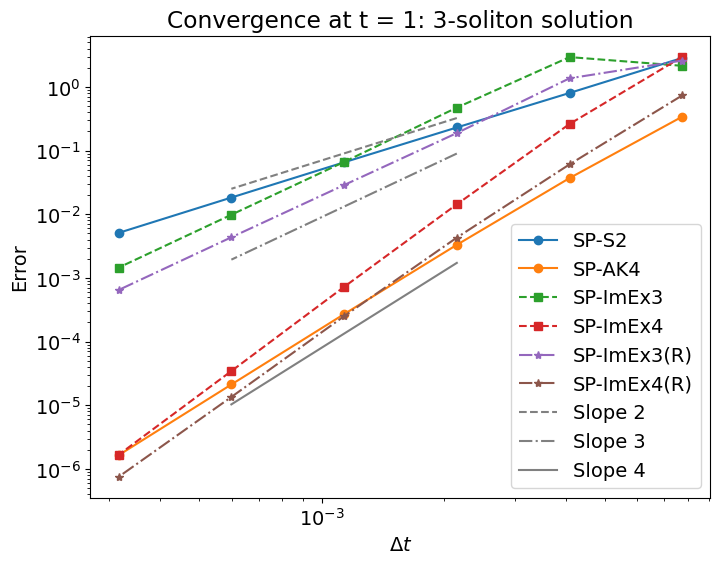

In [16]:
# Font size    
font = {#'family' : 'normal',
'weight' : 'normal',
'size'   : 14}
plt.rc('font', **font)

if q == 8:
    st_in = 4; en_in = 8;
    Coef = [7e2,9e3,2e4]    
elif q == 18:
    st_in = 2; en_in = 5;
    Coef = [7e4,9e6,8e7]
    
plt.figure(figsize=(8,6))
plt.plot(dts,E_SP_TS[0],'o-',label = 'SP-%s'%Mthds_SP[0])
plt.plot(dts,E_SP_TS[1],'o-',label = 'SP-%s'%Mthds_SP[1])
plt.plot(dts,E_SP_ImEx[0],'s--',label = 'SP-%s'%Mthds_B[0])
plt.plot(dts,E_SP_ImEx[1],'s--',label = 'SP-%s'%Mthds_B[1])
plt.plot(dts,E_SP_ImEx_MR[0],'*-.',label = 'SP-%s'%Mthds_R[0])
plt.plot(dts,E_SP_ImEx_MR[1],'*-.',label = 'SP-%s'%Mthds_R[1])
plt.xscale("log"); plt.yscale("log")
plt.xlabel("$\Delta t$"); plt.ylabel('Error')

plt.plot(dts[st_in:en_in], Coef[0]*dts[st_in:en_in]**2, "--", color="gray",label = 'Slope 2')
plt.plot(dts[st_in:en_in], Coef[1]*dts[st_in:en_in]**3, "-.", color="gray",label = 'Slope 3')
plt.plot(dts[st_in:en_in], Coef[2]*dts[st_in:en_in]**4, "-", color="gray",label = 'Slope 4')
plt.title("Convergence at t = %1d: %d-soliton solution"%(tf,sol))
#plt.ylim((1e-5, 1e1))
plt.legend(ncol=1) 

plt.savefig('./Figures/%s/%s_SP_x_Diff_t_Mthds_Err_Conv_t_%d.pdf'%(eqn,eqn,tf),format='pdf', bbox_inches="tight",transparent=True)


## End